In [ ]:
'''
About the data:
"This dataset provides a detailed overview of gym members' exercise routines, physical attributes, and fitness metrics. It contains 973 
samples of gym data, including key performance indicators such as heart rate, calories burned, and workout duration. Each entry also 
includes demographic data and experience levels, allowing for comprehensive analysis of fitness patterns, athlete progression, and 
health trends."

From: https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset

#######################################################################################################################################

In this analysis we

    1. test the hypothesis that male and female gym members burn the same amount of calories on average and conduct both
        an equal-tailed and one-sided hypothesis test
and
    2. use linear regression to select features within the pipeline and predict the number of calories burned 
        using the rest of the data

'''

In [41]:
'''
1) Hypothesis testing
Question: Do male and female gym members burn the same number of calories on average?

Conducting an Equal-tailed Test
H₀: μ₁ = μ₂ ie. Male and female gym members burn the same number of calories on average.
H₁: μ₁ ≠ μ₂ ie. Male and female gym members do not burn the same number of calories on average.

'''

import pandas as pd
df = pd.read_csv("gym_data.csv")
new = df[['Gender', 'Calories_Burned']].dropna()
male_calories = new[new['Gender'] == 'Male']['Calories_Burned']
female_calories = new[new['Gender'] == 'Female']['Calories_Burned']

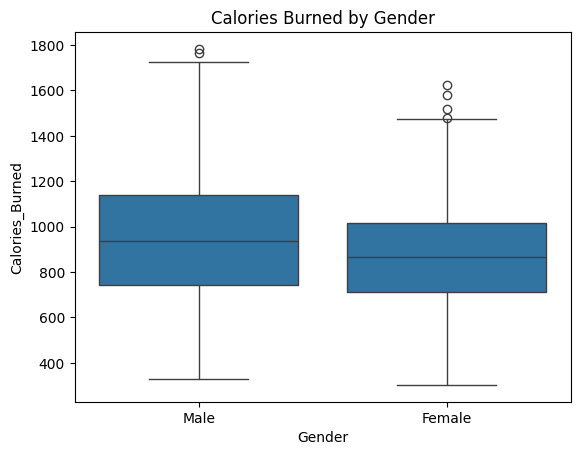

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Gender', y='Calories_Burned', data=df)
plt.title("Calories Burned by Gender")
plt.show()

In [43]:
import scipy.stats as stats

t_stat, pvalue = stats.ttest_ind(male_calories, female_calories, equal_var=False)
# pvalue=np.float64(2.0102943133909015e-06)

print('p-value = ', pvalue)
print('male mean cals burned: %.3f' % male_calories.mean())
print('female mean cals burned: %.3f' % female_calories.mean()) 

# p-value =  2.0102943133909015e-06
# male mean cals burned: 944.456
# female mean cals burned: 862.249

p-value =  2.0102943133909015e-06
male mean cals burned: 944.456
female mean cals burned: 862.249


In [ ]:
''' 
Since the p-value is less than/equal to 0.001, we can conclude that there is very strong evidence against the hypothesis that male and 
female gym members burn the same amount of calories on average based on the observed data. From the sample means, we can see that male 
gym members burn more calories than female gym members on average.

'''

In [150]:
'''
Conducting a One-sided Test
H₀: μ₁ = μ₂ ie. Male and female gym members burn the same number of calories on average.
H₁: μ₁ > μ₂ ie. Male gym members burn more calories than female gym members on average.

'''

if t_stat > 0:
    pvalue_onesided = pvalue/2
else:
    pvalue_onesided = 1 - pvalue/2

print('one-sided test p-value = ', pvalue_onesided)
# one-sided test p-value =  1.0051471566954508e-06

'''
Since the one-sided test p-value is less than/equal to 0.001, we can conclude that there is very strong evidence against the hypothesis that
on average, male and female gym members burn the same amount of calories based on the observed data. Furthermore, it seems reasonable to 
assume that male gym members burn more calories than female gym members on average.

'''

one-sided test p-value =  1.0051471566954508e-06


In [ ]:
'''
2) Predictive modeling
Question: Can we predict calories burned per session using member characteristics and workout data?

Hypotheses:
- Male gym members burn more calories on average than female gym members
- Of the workout types, Cardio is correlated with burning the most calories
- A longer session duration is correlated with burning more calories
- A higher water intake may be correlated with burning more calories

Generally unsure about Age, BPM, and Workout Frequency as various factors could cause competing trends amoung these features.

'''

In [44]:
categorical_features = ['Gender','Workout_Type']
numerical_features = ['Age','Weight (kg)','Height (m)','Max_BPM','Avg_BPM', 'Resting_BPM','Session_Duration (hours)','Fat_Percentage', 
                   'Water_Intake (liters)','Workout_Frequency (days/week)','Experience_Level','BMI']
target_name = 'Calories_Burned'

X = df[numerical_features + categorical_features]
y = df[target_name]

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop='first'), categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ('feature_selection', SelectFromModel(LinearSVR(epsilon=0.01, max_iter=25000))), # lasso regression
           ("regression", LinearRegression())]
)

reg.fit(X_train, y_train)

scores = cross_val_score(reg, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# 0.87 accuracy with a standard deviation of 0.05
# 5-fold cross-validated R² = 0.87 ± 0.05 means that the model generalizes well.

y_pred = reg.predict(X_test)

0.87 accuracy with a standard deviation of 0.05


In [46]:
reg

,steps,"[('preprocessor', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [47]:
from sklearn.metrics import root_mean_squared_error

print("R² score: %.3f" % reg.score(X_test, y_test)) # score method returns R^2 for regressors by default
print("RMSE: %.3f" % root_mean_squared_error(y_test, y_pred))

# R² score: 0.868
# RMSE: 97.690

R² score: 0.868
RMSE: 97.690


In [ ]:
'''
From the output, the model explains 86.8% of the variance in y_test, the set of true calories burned among gym members. 
The average magnitude of the model's prediction errors is 97.7 calories from the true value.

Thus, the model is moderately accurate in its predictive performance. Although it captures most of the variability in calories burned, an 
average error of around 98 calories makes it somewhat imprecise for reliably estimating individual calorie expenditure among gym members.
'''

In [48]:
# Regressed coefficients:
coefficients = reg.named_steps['regression'].coef_
feature_names = reg.named_steps['feature_selection'].get_feature_names_out()

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
print(coef_df.sort_values(by="Coefficient", ascending=False))

#   Feature  Coefficient
# 0      x6   247.548701
# 1     x12    85.698388
# 3     x14    -4.135166
# 2     x13    -5.855987
# 4     x15   -13.960060

# Issue: does not show feature names!

  Feature  Coefficient
0      x6   247.548701
1     x12    85.698388
3     x14    -4.135166
2     x13    -5.855987
4     x15   -13.960060


In [49]:
def get_pipeline_coefficients(fitted_pipeline):
    """
    Returns a DataFrame of selected features and their regression coefficients from a fitted pipeline
    with ColumnTransformer, SelectFromModel, and LinearRegression.
    """
    preprocessor = fitted_pipeline.named_steps['preprocessor']
    selector = fitted_pipeline.named_steps['feature_selection']
    reg = fitted_pipeline.named_steps['regression']

    # Get transformed feature names
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        else:  # categorical
            feature_names.extend(transformer.get_feature_names_out(cols))

    # Map selected features to coefficients
    selected_features = [feature_names[i] for i in selector.get_support(indices=True)]
    coef_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': reg.coef_
    }).sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

    return coef_df

coef_df = get_pipeline_coefficients(reg)
print(coef_df)

#                     Feature  Coefficient
# 0  Session_Duration (hours)   247.548701
# 1               Gender_Male    85.698388
# 2     Workout_Type_Strength    -4.135166
# 3         Workout_Type_HIIT    -5.855987
# 4         Workout_Type_Yoga   -13.960060

                    Feature  Coefficient
0  Session_Duration (hours)   247.548701
1               Gender_Male    85.698388
2     Workout_Type_Strength    -4.135166
3         Workout_Type_HIIT    -5.855987
4         Workout_Type_Yoga   -13.960060


In [ ]:
'''
The model’s coefficients indicate that Session_Duration (hours) is the strongest predictor of calories burned, with each additional
hour of exercise associated with an increase of approximately 248 calories. Male participants are predicted to burn about 86 more 
calories than female participants, holding other factors constant. Among workout types, Yoga has the largest negative effect, 
reducing predicted calories burned by around 14 calories relative to Cardio, the baseline, while Strength and HIIT sessions have 
smaller negative effects. Overall, the results align with expectations: longer sessions and male participants are associated with
higher calorie expenditure, while all workout types burn fewer calories compared to Cardio.

'''

In [50]:
# Beyond evaluating predictive accuracy: statistical significance testing of the selected features from the model

import statsmodels.api as sm

convert = reg.named_steps['preprocessor']
X_train_pre = convert.transform(X_train) # a NumPy array
X_train_pre_df = pd.DataFrame(X_train_pre, columns=convert.get_feature_names_out())
X_train_pre_df = sm.add_constant(X_train_pre_df) # add col of 1s to fit to intercept

y_train_reset = y_train.reset_index(drop=True)

ols_model = sm.OLS(y_train_reset, X_train_pre_df).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2216.
Date:                Mon, 25 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:12:15   Log-Likelihood:                -3966.2
No. Observations:                 778   AIC:                             7966.
Df Residuals:                     761   BIC:                             8046.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [51]:
# Bonferroni correction
k = 5
alpha = 0.05
alpha_adj = alpha / k

def appendcatg(lst):
    L = []
    for col in lst:
        if col.startswith('Session'):
            L.append('num__' + col)
        else:
            L.append('cat__' + col)
    return L
model_features = appendcatg(coef_df['Feature'].tolist())

L_regular = []
L_bonferroni = []

for col in model_features:
    if ols_model.pvalues[col] < alpha:
        L_regular.append(col)
        if ols_model.pvalues[col] < alpha_adj:
            L_bonferroni.append(col)

print('alpha = 0.05 valid features: ', L_regular)
print('Bonferroni valid features: ', L_bonferroni)    

# alpha = 0.05 valid features:  ['num__Session_Duration (hours)', 'cat__Gender_Male']
# Bonferroni valid features:  ['num__Session_Duration (hours)', 'cat__Gender_Male']

alpha = 0.05 valid features:  ['num__Session_Duration (hours)', 'cat__Gender_Male']
Bonferroni valid features:  ['num__Session_Duration (hours)', 'cat__Gender_Male']


In [ ]:
'''
Although the predictive model selected five features, statistical testing revealed that only two were individually significant predictors of
calorie expenditure (p < 0.05, and Bonferroni corrected). This suggests that while the model performs adequately for prediction, not all 
selected features show strong independent statistical evidence of association, possibly due to multicollinearity or limited sample size.

'''